In [1]:
import common

import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
from datetime import datetime
from zoneinfo import ZoneInfo
import wandb

In [2]:
common.wandb_login_init('tiny_vit_21m_384.dist_in22k_ft_in1k')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kerneld82 (kerneld). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


train_time = tiny_vit_21m_384.dist_in22k_ft_in1k


In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'tiny_vit_21m_384.dist_in22k_ft_in1k' # 'resnet50' 'efficientnet-b0', ...

# training config
trn_img_size = 384
tst_img_size = 384
LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 32
num_workers = 12
augment_ratio = 200

wandb.config.update({
    "learning_rate": LR,
    "architecture": model_name,
    "dataset": "custom-dataset",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_image_size": trn_img_size,
    "test_image_size": tst_img_size,
    "num_workers": num_workers,
    'augment_ratio' : augment_ratio,
})

In [4]:
# 시드를 고정합니다.
SEED = 42

common.set_seed(SEED)

In [5]:
device

device(type='cuda')

### Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [6]:
trn_transform = common.create_trn_transform(trn_img_size)
trn_aug_transform = common.create_trn_aug_transform(trn_img_size)
tst_transform = common.create_tst_transform(tst_img_size)

In [7]:
# Dataset 정의
trn_dataset, val_dataset = common.train_dataset_split(
    "datasets_fin/train.csv",
    "datasets_fin/train/",
    trn_transform = trn_transform,
    trn_aug_transform = trn_aug_transform,
    tst_transform = tst_transform,
    augment_ratio = augment_ratio,
    train_size=0.8, 
    random_state=SEED
)

tst_dataset = common.ImageDataset(
    "datasets_fin/sample_submission.csv",
    "datasets_fin/test/",
    transform = tst_transform
)

print("최종", len(trn_dataset), len(val_dataset), len(tst_dataset))

[dataset_split] 훈련 세트: 1387 샘플
[dataset_split] 검증 세트: 347 샘플
최종 277400 347 3140


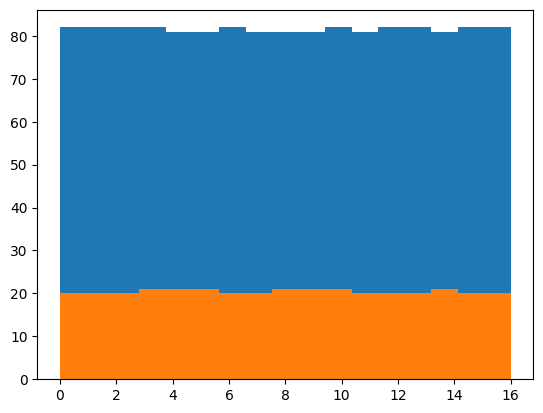

In [8]:
import matplotlib.pyplot as plt
plt.hist(trn_dataset.df[:,1], bins=17)
plt.hist(val_dataset.df[:,1], bins=17)
plt.show()

In [9]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [10]:
len(timm.list_models(pretrained=True))

1298

In [11]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [12]:
common.train_with_start_end_epoch(seed = SEED, 
                                  tst_img_size = tst_img_size,
                                  batch_size = BATCH_SIZE,
                                  start_epoch_inclusive = 0, 
                                  end_epoch_exclusive = EPOCHS, 
                                  augment_ratio = augment_ratio,
                                  trn_loader = trn_loader, 
                                  val_loader = val_loader, 
                                  model = model, 
                                  model_name = model_name, 
                                  optimizer = optimizer, 
                                  loss_fn = loss_fn, 
                                  device = device, 
                                  is_save_model_checkpoint = True, 
                                  is_evaluate_train_valid = True)

Loss: 0.0011: 100%|██████████| 8669/8669 [54:13<00:00,  2.66it/s]


train_loss: 0.1012
train_acc: 0.9641
train_f1: 0.9640
epoch: 0.0000

Model checkpoint saved. filename: checkpoint-tiny_vit_21m_384.dist_in22k_ft_in1k_seed_42_epoch_0_isFull_False.pt



Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]



final_train_loss: 0.024430299672151073
final_train_accuracy: 0.9919718817591925
final_train_f1: 0.9920036900032961
final_valid_loss: 0.1966108571478716
final_valid_accuracy: 0.9481268011527377
final_valid_f1: 0.948888263439347
train's error preds count: 2227/277400, {7: 146, 3: 797, 14: 971, 4: 168, 13: 87, 11: 5, 10: 16, 8: 20, 12: 7, 6: 4, 1: 5, 2: 1}
valid's error preds count: 18/347, {3: 8, 7: 6, 4: 4}




Loss: 0.0028: 100%|██████████| 8669/8669 [53:58<00:00,  2.68it/s]


train_loss: 0.0292
train_acc: 0.9906
train_f1: 0.9905
epoch: 1.0000

Model checkpoint saved. filename: checkpoint-tiny_vit_21m_384.dist_in22k_ft_in1k_seed_42_epoch_1_isFull_False.pt



Evaluating: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]



final_train_loss: 0.04292045990402481
final_train_accuracy: 0.9856849315068493
final_train_f1: 0.9856219178088526
final_valid_loss: 0.2677132935039646
final_valid_accuracy: 0.9510086455331412
final_valid_f1: 0.9487021672371284
train's error preds count: 3971/277400, {3: 3091, 4: 251, 14: 154, 11: 272, 10: 50, 12: 34, 0: 47, 13: 27, 7: 17, 1: 8, 6: 2, 9: 9, 15: 5, 16: 2, 8: 2}
valid's error preds count: 17/347, {3: 13, 4: 3, 7: 1}




Loss: 0.0041: 100%|██████████| 8669/8669 [53:57<00:00,  2.68it/s]


train_loss: 0.0191
train_acc: 0.9939
train_f1: 0.9938
epoch: 2.0000

Model checkpoint saved. filename: checkpoint-tiny_vit_21m_384.dist_in22k_ft_in1k_seed_42_epoch_2_isFull_False.pt



Evaluating: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]



final_train_loss: 0.005719542505671927
final_train_accuracy: 0.9982011535688536
final_train_f1: 0.9982020103478813
final_valid_loss: 0.15268063385916653
final_valid_accuracy: 0.9711815561959655
final_valid_f1: 0.9714158390628979
train's error preds count: 499/277400, {4: 34, 6: 45, 1: 96, 3: 175, 7: 21, 14: 50, 10: 30, 12: 11, 8: 19, 11: 3, 15: 5, 13: 7, 16: 3}
valid's error preds count: 10/347, {4: 2, 7: 3, 3: 5}




Loss: 0.0140: 100%|██████████| 8669/8669 [53:58<00:00,  2.68it/s]


train_loss: 0.0142
train_acc: 0.9955
train_f1: 0.9955
epoch: 3.0000

Model checkpoint saved. filename: checkpoint-tiny_vit_21m_384.dist_in22k_ft_in1k_seed_42_epoch_3_isFull_False.pt



Evaluating: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]



final_train_loss: 0.01780548888199937
final_train_accuracy: 0.9944664744051911
final_train_f1: 0.9944528170679772
final_valid_loss: 0.22825047803813836
final_valid_accuracy: 0.962536023054755
final_valid_f1: 0.9630568018392914
train's error preds count: 1535/277400, {14: 936, 4: 260, 3: 127, 11: 56, 7: 80, 0: 22, 6: 8, 10: 10, 12: 22, 16: 1, 5: 2, 9: 1, 13: 8, 8: 1, 2: 1}
valid's error preds count: 13/347, {3: 5, 4: 2, 7: 6}




Loss: 0.0001: 100%|██████████| 8669/8669 [1:04:34<00:00,  2.24it/s]


train_loss: 0.0115
train_acc: 0.9964
train_f1: 0.9964
epoch: 4.0000

Model checkpoint saved. filename: checkpoint-tiny_vit_21m_384.dist_in22k_ft_in1k_seed_42_epoch_4_isFull_False.pt



Evaluating: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


final_train_loss: 0.0018499927735593
final_train_accuracy: 0.9994448449891853
final_train_f1: 0.999443576310097
final_valid_loss: 0.20832059580160686
final_valid_accuracy: 0.9711815561959655
final_valid_f1: 0.9711241587588724
train's error preds count: 154/277400, {3: 41, 4: 19, 0: 11, 14: 32, 7: 38, 1: 7, 12: 2, 9: 1, 13: 2, 10: 1}
valid's error preds count: 10/347, {3: 3, 4: 1, 7: 6}


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [14]:
common.pred_and_save_to_csv(model, tst_loader, device, "pred.csv")

100%|██████████| 99/99 [00:27<00:00,  3.64it/s]


In [15]:
# wandb 실행 종료
wandb.finish()

final_train_accuracy,▄▁▇▅█
final_train_f1,▄▁▇▅█
final_train_loss,▅█▂▄▁
final_valid_accuracy,▁▂█▅█
final_valid_f1,▁▁█▅█
final_valid_loss,▄█▁▆▄
train_acc,▁▇▇██
train_f1,▁▇▇██
train_loss,█▂▂▁▁
final_train_accuracy,0.99944
final_train_f1,0.99944


In [16]:
import sys
sys.exit('아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.')

SystemExit: 아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 수동으로 특정 체크포인트부터 이어서 학습하기 위한 부분


In [ ]:
checkpoint = common.load_model_checkpoint("checkpoint-resnet34_seed_42_epoch_0_isFull_False.pt", model, optimizer, device)

In [ ]:
next_epoch = checkpoint['epoch'] + 1

common.train_with_start_end_epoch(seed = checkpoint['seed'],
                           tst_img_size = checkpoint['tst_img_size'],
                           batch_size = checkpoint['batch_size'],
                           start_epoch_inclusive = next_epoch, 
                           end_epoch_exclusive = next_epoch + 2, 
                           augment_ratio = augment_ratio,
                           trn_loader = trn_loader,
                           val_loader = val_loader,
                           model = model,
                           model_name = model_name,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device,
                           is_save_model_checkpoint = True,
                           is_evaluate_train_valid = True)

Loss: 1.8031: 100%|██████████| 69/69 [00:09<00:00,  7.38it/s]


train_loss: 2.0972
train_acc: 0.3326
train_f1: 0.3136
epoch: 1.0000

Model checkpoint saved. filename: checkpoint-resnet34_seed_42_epoch_1_isFull_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]



final_train_loss: 1.790640383526899
final_train_accuracy: 0.4349408553230209
final_train_f1: 0.4316298116099343
final_valid_loss: 1.2533869663874309
final_valid_accuracy: 0.5966029723991507
final_valid_f1: 0.5529343340352267




Loss: 1.4048: 100%|██████████| 69/69 [00:09<00:00,  7.48it/s]


train_loss: 1.6951
train_acc: 0.4449
train_f1: 0.4397
epoch: 2.0000

Model checkpoint saved. filename: checkpoint-resnet34_seed_42_epoch_2_isFull_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


final_train_loss: 1.4995038284771685
final_train_accuracy: 0.5104640582347588
final_train_f1: 0.5326523791669887
final_valid_loss: 1.00657608906428
final_valid_accuracy: 0.6624203821656051
final_valid_f1: 0.6142918510958036
